In this notebook, we will cover some simple examples of how to learn representations on a graph (Colloquially, what would be called "Doing ML on a graph") by leveraging graph convolutions.

We will use the CoraGraphDataset from https://graphsandnetworks.com/the-cora-dataset/
According to their website, "The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words."

Nodes in this graph represent publications. Nodes are connected with directional edges based on citations with a directional relationship (Making this a directional graph) if one publication cites another. This is probably acyclic making it a DAG because publications don't cite future publications, but whether or not this graph has cycles doesn't affect this analysis.

In [1]:
# Please go to dgl.ai and https://pytorch.org/ to get the download instructions for your OS/cuda version/etc.
# Below are some example commands that might work if you want to disable GPU and install on windows.
# conda install -c dglteam dgl
# conda install pytorch torchvision torchaudio cpuonly -c pytorch

The main background here is that we will be applying convolutions over a graph instead of convolutions over a grid, such as an image or test series. In Image convolution, the new representation for each pixel has inputs from each surrounding pixel. You take the surrounding pixels, multiply their values by your kernel which is learned, and add up all the results, to compute the new representation for a given node.

In graph convolutions, we have a differing number of inputs feeding into your current node. We also don't have a grid structure to support a normal convolution, so instead we must learn a representation that applies to each surrounding node.  This is similar to applying the same vector multiplication to each of the surrounding pixel vectors. We then have a summarization function such as mean() to compress all of the input vectors coming into a node into its new representation, often followed by passing through a non-linear transformation like a leaky relu.

For years, doing any graph convolutions required a lot of custom code within Tensorflow or Pytorch. This style of modeling had not really existed before we had at least those tools due to its impracticality to implement with older clunkier tools.

Nowadays, most of the engineering to set up graph learning is very easy for us due to tools that handle graph convolutions for us, such as DGL which is agnotistic to differential backend, or Pytorch Geometric.

In this tutorial, we cover DGL, loosely following the tutorials from dgl.ai

In [2]:
# imports
import numpy as np
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.data

import matplotlib.pyplot as plt
import networkx as nx

In [3]:
# Reading in the dataset
dataset = dgl.data.CoraGraphDataset()
print('Number of categories:', dataset.num_classes)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Number of categories: 7


In [4]:
# our dataset has 1 graph
g = dataset[0]


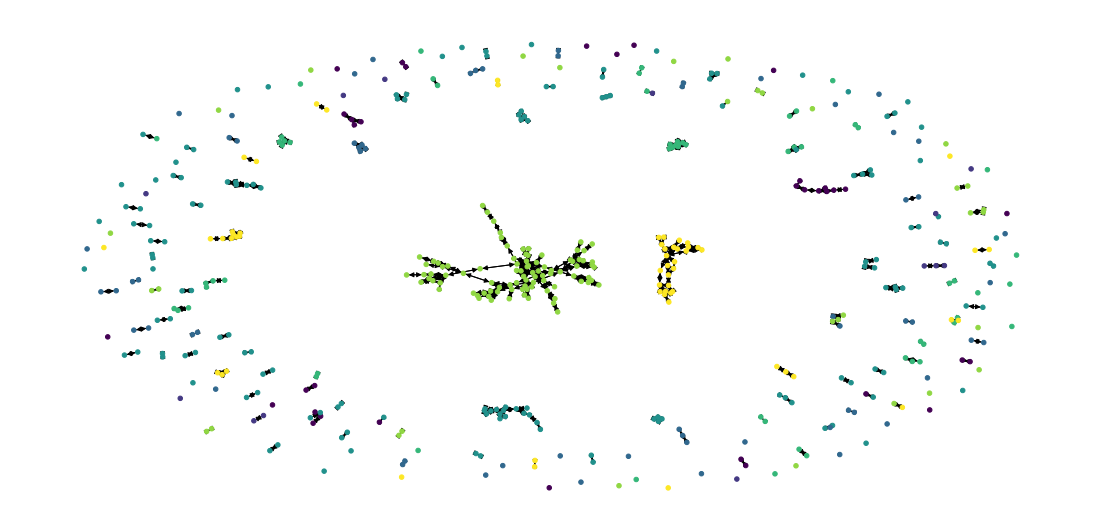

In [5]:
# if we want to visualize only a subset of the graph to run faster
num_visualize = 500
if num_visualize is not None:
    g2 = g.subgraph(np.arange(num_visualize))
else:
    g2 = g

options = {
    'node_size': 20,
    'width': 1,
    'node_color' : g2.ndata['label']
}
# dgl doesnt visualize networks. Convert to networkx so we can use their visualization tool.
# Here, we visualize the label of each node and the edges, but don't visualize the features of nodes.
G = dgl.to_networkx(g2)
plt.figure(figsize=[15,7])
nx.draw(G, **options)

We have 2708 nodes, each with 1433 binary features.
Our edges have no interesting features.
Note that we do not have self connections within this graph. If you want to try to fiddle with your model, feel free to add self-connections DGLGraph.add_edges

In [6]:
print('Node features')
print(g.ndata)
print('Edge features')
print(g.edata)

Node features
{'train_mask': tensor([False, False, False,  ..., False, False, False]), 'label': tensor([4, 4, 4,  ..., 4, 3, 3]), 'val_mask': tensor([False, False,  True,  ..., False, False, False]), 'test_mask': tensor([ True,  True, False,  ..., False, False, False]), 'feat': tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0526, 0.0000]])}
Edge features
{'__orig__': tensor([  298,  9199,  1153,  ..., 10415,  5255,  6356])}


### Modeling
Here we define a model. Note that we are free to define GraphConvs that convolve the various edges pointing into a node, but we can also use non-graph convolutional layers to perform transformations without graph convolutions.

Note that the GraphConv layer in dgl.nn handles all the graphical details for us, such as routing the content from related edges into the computation for a given node as we progress through the network layers.

In [7]:

from dgl.nn import GraphConv
from torch import nn
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.linear = nn.Linear(h_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.leaky_relu(h, .2)
        
        h = self.linear(h)
        h = F.leaky_relu(h, .2)
        
        h = self.conv2(g, h)
        return h

Here I set up a basic training procedure. Note that this is just a prototype and we have ignored minibatch optimization, just to show we are capable of learning on a graph. Feel free to expand on this to improve performance by implementing minibatches.

In [8]:
def train(g, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-3)
    best_val_acc = 0
    best_test_acc = 0

    features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']
    for e in range(100):
        # Forward
        logits = model(g, features)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 5 == 0:
            print('In epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})'.format(
                e, loss, val_acc, best_val_acc, test_acc, best_test_acc))
model = GCN(g.ndata['feat'].shape[1], 512, dataset.num_classes)
train(g, model)

In epoch 0, loss: 1.947, val acc: 0.164 (best 0.164), test acc: 0.146 (best 0.146)


C:\Users\leedt\anaconda3\envs\tf2\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In epoch 5, loss: 1.891, val acc: 0.266 (best 0.266), test acc: 0.269 (best 0.269)
In epoch 10, loss: 1.660, val acc: 0.548 (best 0.548), test acc: 0.530 (best 0.530)
In epoch 15, loss: 1.029, val acc: 0.740 (best 0.740), test acc: 0.763 (best 0.763)
In epoch 20, loss: 0.385, val acc: 0.794 (best 0.800), test acc: 0.797 (best 0.802)
In epoch 25, loss: 0.116, val acc: 0.796 (best 0.800), test acc: 0.810 (best 0.802)
In epoch 30, loss: 0.049, val acc: 0.794 (best 0.800), test acc: 0.806 (best 0.802)
In epoch 35, loss: 0.039, val acc: 0.796 (best 0.800), test acc: 0.800 (best 0.802)
In epoch 40, loss: 0.055, val acc: 0.790 (best 0.800), test acc: 0.801 (best 0.802)
In epoch 45, loss: 0.139, val acc: 0.774 (best 0.800), test acc: 0.780 (best 0.802)
In epoch 50, loss: 0.087, val acc: 0.784 (best 0.800), test acc: 0.793 (best 0.802)
In epoch 55, loss: 0.074, val acc: 0.792 (best 0.800), test acc: 0.800 (best 0.802)
In epoch 60, loss: 0.068, val acc: 0.784 (best 0.800), test acc: 0.794 (best 

### Edge Prediction
That's fine, but we did a very basic operation of label prediction. What if we wanted a more complicated task, such as edge prediction? This is the task of looking at two nodes and asking "Should there be an edge between them?"

Most of this section is taken from https://docs.dgl.ai/tutorials/blitz/4_link_predict.html#sphx-glr-tutorials-blitz-4-link-predict-py

#### Overview of Link Prediction with GNN
Many applications such as social recommendation, item recommendation, knowledge graph completion, etc., can be formulated as link prediction, which predicts whether an edge exists between two particular nodes. This tutorial shows an example of predicting whether a citation relationship, either citing or being cited, between two papers exists in a citation network.

This tutorial formulates the link prediction problem as a binary classification problem as follows:

* Treat the edges in the graph as positive examples.

* Sample a number of non-existent edges (i.e. node pairs with no edges between them) as negative examples.

* Divide the positive examples and negative examples into a training set and a test set.

* Evaluate the model with any binary classification metric such as Area Under Curve (AUC).

Note

In [12]:
# Adding an import to handle sparse edge connections
import scipy.sparse as sp

In [13]:
# Split edge set for training and testing
u, v = g.edges()

eids = np.arange(g.number_of_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.1)
train_size = g.number_of_edges() - test_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

# Find all negative edges and split them for training and testing
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]

This tutorial randomly picks 10% of the edges for positive examples in the test set, and leave the rest for the training set. It then samples the same number of edges for negative examples in both sets. Feel free to change this ratio. In a real business setting, you would probably want to add tons of extra negative samples, or even randomly generate negative samples during training. This is essentially a free way of generating extra data. Make sure your validation metric handles your imbalanced data distribution though!

In [14]:
from dgl.nn import SAGEConv

# Here, we use SAGEConv instead of GraphConv. This is just to show that GraphConv is not the only possible graph
# Convolution, and you have the freedom to define how you want to calculate the next layer of your graph as a function 
# of the prior.
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [15]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())